# Appyling Fastai v1 on Malaria images dataset

The general approach to classification of images upon the Malaria dataset was taken from lesson 1 of fastai v3 of the courses on Deep Learning.

We will begin creating a neural network that classifies cell images as either "Parasitized" with Malaria, or "Uninfected."
The approach can be summarized as:
1. Create a data object to prepare data for modelling
2. Use create_cnn() to create a learn object
3. Use the learn object to fit model
4. Interpret Results
5. Fine tune model by unfreezing, finding learning rates (LRs), and applying differential LRs.
6. Interpret results
7. Compare models from steps 1-3 and steps 5


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

For all the necessary functions for applying image classification in this application

In [2]:
from fastai.vision import *

Set the batch size for processing.

**bs** stands for *batch size* and is the amound of images you would train at a time. This parameter is helpful when dealing with running out of memory. Making it smaller can fix this issue.

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

True

In order to check whether or not our environment is making use of your setup's GPU, type the following code

In [ ]:
torch.cuda.is_available()

## Step 0: Data organization

We first create a *Path* object using `Path()` in order to view various characteristics about the organization of our data. To do so, we specify the location of our folder that holds the data in relation to our current working directory.

In [1]:
data_folder_location = '../../../kaggle_data/cell_images/'
path = Path(data_folder_location) 

NameError: name 'Path' is not defined

If any questions arise about certain functions / objects, the `help()` or `doc()` functions can be very useful

In [46]:
doc(Path)

To view what exists with the folder, we call 

In [37]:
path.ls()

[PosixPath('../../../kaggle_data/cell_images/Uninfected'),
 PosixPath('../../../kaggle_data/cell_images/models'),
 PosixPath('../../../kaggle_data/cell_images/Parasitized')]

As you can see, the data is labelled by subfolders **Uninfected** and **Parasitized**. So, all images that are classified as *Uninfected* lie within the *Uninfected* folder, and all images classified as *Parasitized* are within the *Parasitized* folder.

## Step 1: Create Data Object

In order to organize our data such that we can train and validate it using `create_cnn()`, we must first create a *data object*. This data object is created using the `ImageDataBunch()`. Further documentation can be found [here](https://docs.fast.ai/vision.data.html#ImageDataBunch).

We use `ImageDataBunch.from_folder()` since the classification labels are organized with folders.

In [39]:
data = ImageDataBunch.from_folder(path, 
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(flip_vert = True, max_warp = 0),
                                  size=224, 
                                  bs=bs).normalize(imagenet_stats)

**Explanation of the above code:**

**path** is the path in which our data lies.

**valid_pct** is a very useful parameter that splits our data into training and validation sets. For instance, using `path.ls()` above showed that our data was not already organized into *training* and *validation* folders but as:

*/Uninfected*

*/Infected*

Using this parameter will split our *Uninfected* and *Parasitzed* folders as such:

*/train/Uninfected*

*/train/Parasitized*

*/valid/Uninfected*

*/valid/Parasitized*

The *=0.2* is the ratio for splitting your training and validation folders, so 80% of data will be training, and 20% of data will be used for model validation.

**df_tfms** takes in function `get_transforms()`. This parameter applies tranformations upon our data in order to provide more data to train upon, and is a good trick to prevent *overfitting* as mentioned during Jeremy Howard's fast.ai v2 lesson 1 lecture. 
* Since we are looking at data from the *top-down*, tranforming our data by "flipping it vertical" makes sense.

**size** is a parameter that makes all images the same shape and size in order for the GPU to perform fast calculations upon.

**bs** stands for *batch size* and is the amound of images you would train at a time. This parameter is helpful when dealing with running out of memory. Making it smaller can fix this issue.

**.normalize(imagenet_stas)** *normalizes* our images. As referenced from the fast.ai course, the RGB channels must have a normalized brightness and variation.

> It really helps train a deep learning model if each one of those red green and blue channels has a mean of zero and a standard deviation of one.



We can now take a look at our data using our *data* object.

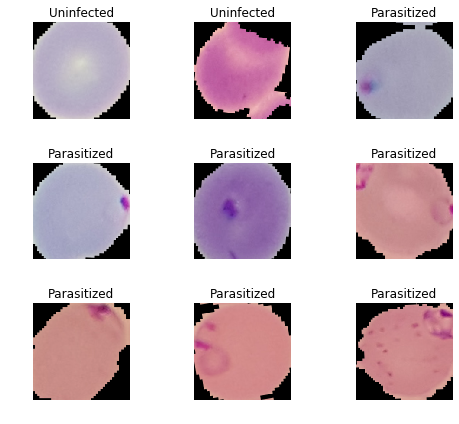

In [40]:
data.show_batch(rows=3, figsize=(7,6))

## Step 2: Training our Model with create_cnn

In order to train our model, we will make use of **Transfer Learning**.

That is, using a model that can efficiently do its job, and making it do whatever it is you would like to do particularly well. In this case, we will use **resnet34** as our pretrained model.

To train our specific model using a convolutional neural network, we will use the `create_cnn()` function. More info on this function can be found with `doc(create_cnn())`.

`create_cnn()` outputs a *learn* object that knows what our data is, and what our model is.

In [3]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)
# first parameter is our data object
# 2nd parameter is our pre-trained model for transfer learning
# metrics parameter specifies how output will be printed to user

NameError: name 'create_cnn' is not defined

In [4]:
# learn.model # to view our model

## Step 3: Fitting our model

In order to fit our model, we will call `learn.fit_one_cycle`. As referenced from the fast.ai v3 course, `fit_one_cycle` provides a
> dramatically more accurate and faster approach to model fitting as found in [this paper](https://arxiv.org/abs/1803.09820).

The parameter in `learn.fit_one_cycle` is the number of epochs, or number of times we will go over our dataset.

In general, it would be advised to start with `4`, but after fitting the model with `8` epochs, and then `6` epochs, `6` provided the best results.

In [43]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy
1,0.238247,0.169523,0.939575
2,0.178478,0.124333,0.954818
3,0.149336,0.112888,0.959354
4,0.147769,0.107147,0.962439
5,0.132354,0.097730,0.966612
6,0.121342,0.095039,0.965886
7,0.122872,0.092978,0.967520
8,0.121441,0.095646,0.966249


In [5]:
learn.save('stage-1') 

NameError: name 'learn' is not defined

`learn.save()` stores our model in subfolder 'model' within the folder our data is in.
We can now load this model in case we ever have to return to it

## Step 4: Interpretting Results

To interpret our classifications, we will use the `ClassificationInterpretation` with the extension of `.from_learner` since we are interpretting from our *learner* object. 

Documentation on `ClassificationInterpretation` can be found [here](https://docs.fast.ai/vision.learner.html#ClassificationInterpretation)

After storing the results in `interp`, we call `interp.top_losses()` to store the top losses and idxs sorted by the largest. 

By seeing the top losses, we can identify what were the most confident classifications that were in fact wrong.

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

True

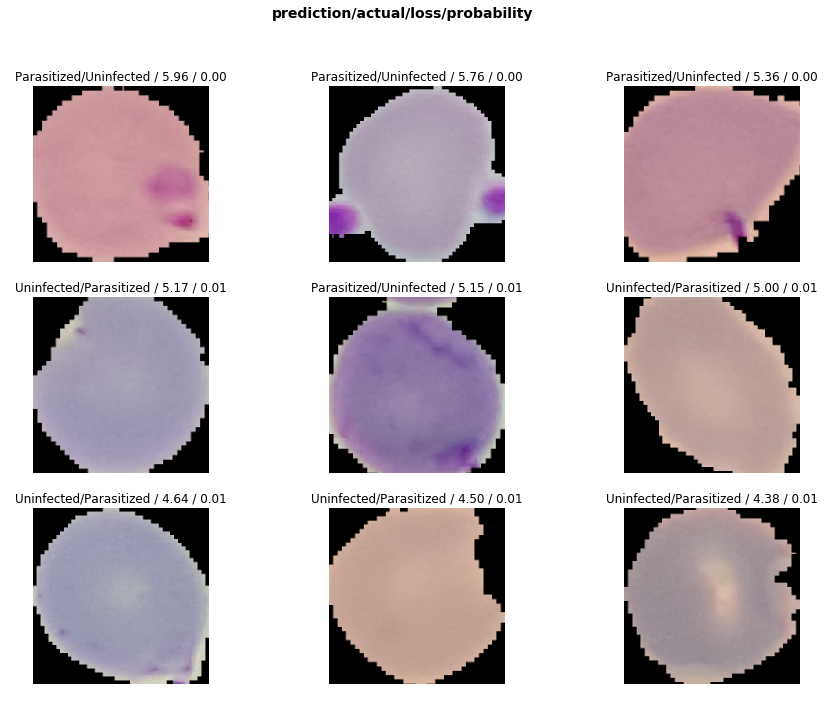

In [15]:
interp.plot_top_losses(9, figsize=(15,11))

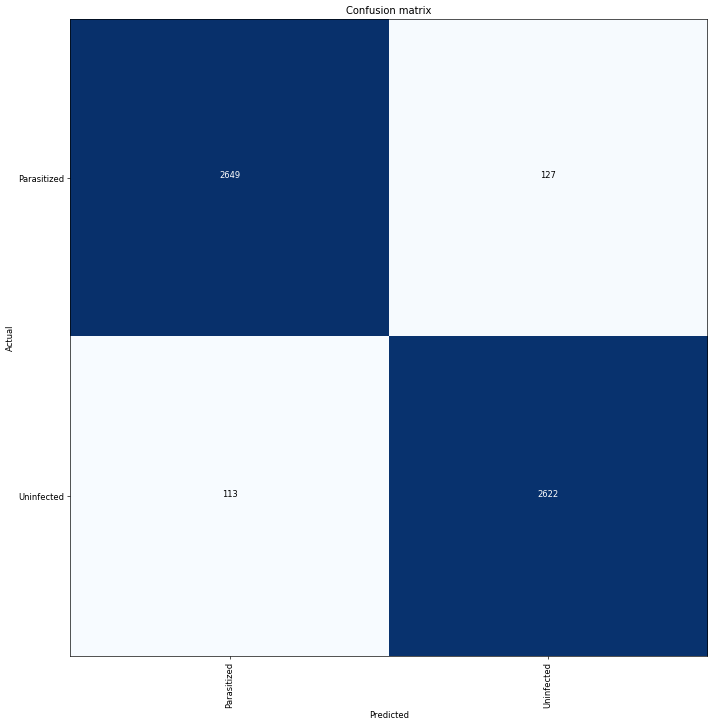

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 127), ('Uninfected', 'Parasitized', 113)]

## Step 5: Unfreezing, finding learning rates (LRs), applying differential LRs

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

### Unfreeze Layers

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(1) # fit after unfreezing all layers

epoch,train_loss,valid_loss,accuracy
1,0.122112,0.099398,0.965161


In [20]:
learn.save('stage-1-unfreeze') # save model

In [21]:
learn.load('stage-1'); # load previous model

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


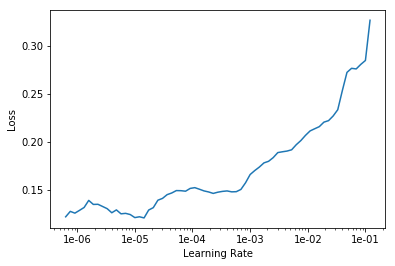

In [23]:
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.131441,0.113598,0.958628
2,0.131634,0.111730,0.958810


Unfortunately, the accuracy looks to have not improved very much as opposed to freezing the original resnet34 layers

That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [25]:
data = ImageDataBunch.from_folder(path, 
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(flip_vert = True, max_warp = 0),
                                  size=224, 
                                  bs=bs//2).normalize(imagenet_stats)

In [26]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 29373706.36it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


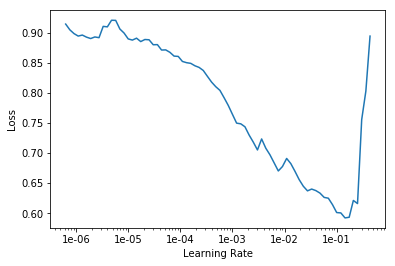

In [27]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy
1,0.178047,0.139027,0.956632


In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]